# Notebook for rereferencing, example with bipolar, CAR and iterable rereference (user defined number of channels).

In this notebook we will explore different re-referencing methods and observe how they impact the estimated features. Only STN-LFP data is going to be used, and we will visualize the features for the cases with:

- no re-referencing
- bipolar re-referecing: we subtract from a given the channel the averaged signal of the channel below it, in default mode it's done for LFP channels. Eg. LFP channel 2 is the reference for LFP channel 1
- CAR -> common averaging re-referencing: we subtract from all channels their common average.

We will also show how the user can set up the list of channels in which respect the re-reference is performed.

In [1]:
import os
import sys
import py_neuromodulation as nm
import xgboost
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
    nm_stats
)
from sklearn import metrics, model_selection
import json
import matplotlib.pyplot as plt
import numpy as np
import re

# change root directory of the project
SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
if SCRIPT_DIR.split("/")[-1] == "py_neuromodulation":
    # this check is necessary, so we can also run the script from the root directory
    SCRIPT_DIR = os.path.join(SCRIPT_DIR, "examples")

sys.path.append(os.path.dirname(SCRIPT_DIR))

# Reload imports to get changes in other scripts
%load_ext autoreload
%autoreload 2

We will use the same data from example_BIDS.ipynb, but we will provide a different path for the output data.

Look Issue for cell below nm_IO.py

In [2]:
sub = "008"
ses = "EcogLfpMedOff01"
task = "SelfpacedRotationR"
acq = "StimOff"
run = 1
datatype = "ieeg"

# Define run name and access paths in the BIDS format.
RUN_NAME = f"sub-{sub}_ses-{ses}_task-{task}_acq-{acq}_run-{run}"

PATH_RUN = os.path.join(
    (os.path.join(SCRIPT_DIR, "data")),
    f"sub-{sub}",
    f"ses-{ses}",
    datatype,
    RUN_NAME,
)
PATH_BIDS = "/home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/BIDS_data"


(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
);

Extracting parameters from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/BIDS_data/sub-008/ses-EcogLfpMedOff01/ieeg/sub-008_ses-EcogLfpMedOff01_task-SelfpacedRotationR_acq-StimOff_run-1_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/BIDS_data/sub-008/ses-EcogLfpMedOff01/ieeg/sub-008_ses-EcogLfpMedOff01_task-SelfpacedRotationR_acq-StimOff_run-1_channels.tsv.
Reading electrode coords from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/BIDS_data/sub-008/ses-EcogLfpMedOff01/ieeg/sub-008_ses-EcogLfpMedOff01_space-MNI152NLin2009bAsym_electrodes.tsv.


### Default
Reference must be either 'default', 'None' or an iterable with the desired re-referencing for each channel. This iterable needs to be the same length as `ch_names`. We start with default, which is what was done in all other examples:

In [3]:
# Provide a path for the output data. Each re-referencing method has their PATH_OUT
PATH_OUT = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "default")
nm_channels_default = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference='default',
    bads=raw.info["bads"],
    new_names="default",
    used_types=("seeg","dbs"),  # We focus only on LFP data
    target_keywords=("ANALOG_R_ROTA_CH",),
)

In [4]:
nm_channels_default

,name,rereference,used,target,type,status,new_name
0,LFP_R_01_STN_BS,LFP_R_16_STN_BS,1,0,dbs,good,LFP_R_01_STN_BS-LFP_R_16_STN_BS
1,LFP_R_02_STN_BS,LFP_R_01_STN_BS,1,0,dbs,good,LFP_R_02_STN_BS-LFP_R_01_STN_BS
2,LFP_R_03_STN_BS,LFP_R_02_STN_BS,1,0,dbs,good,LFP_R_03_STN_BS-LFP_R_02_STN_BS
3,LFP_R_04_STN_BS,LFP_R_03_STN_BS,1,0,dbs,good,LFP_R_04_STN_BS-LFP_R_03_STN_BS
4,LFP_R_05_STN_BS,LFP_R_04_STN_BS,1,0,dbs,good,LFP_R_05_STN_BS-LFP_R_04_STN_BS
5,LFP_R_06_STN_BS,LFP_R_05_STN_BS,1,0,dbs,good,LFP_R_06_STN_BS-LFP_R_05_STN_BS
6,LFP_R_07_STN_BS,LFP_R_06_STN_BS,1,0,dbs,good,LFP_R_07_STN_BS-LFP_R_06_STN_BS
7,LFP_R_08_STN_BS,LFP_R_07_STN_BS,1,0,dbs,good,LFP_R_08_STN_BS-LFP_R_07_STN_BS
8,LFP_R_09_STN_BS,LFP_R_08_STN_BS,1,0,dbs,good,LFP_R_09_STN_BS-LFP_R_08_STN_BS
9,LFP_R_10_STN_BS,LFP_R_09_STN_BS,1,0,dbs,good,LFP_R_10_STN_BS-LFP_R_09_STN_BS


In [5]:
stream_default = nm.Stream(
    settings=None,
    nm_channels=nm_channels_default,
    path_grids=None,
    verbose=True,
)

stream_default.reset_settings()
stream_default.settings["preprocessing"]["re_referencing"] = True
stream_default.settings['preprocessing']['preprocessing_order'] = [
            "re_referencing"
        ]

stream_default.settings['features']['fft'] = True

stream_default.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

# stream_default.run(
#     data=data,
#     out_path_root=PATH_OUT,
#     folder_name=RUN_NAME,
# )

No Error occurred when testing the settings.


### Use common averaging re-reference
As we want to re-reference all LFP channels, but no re-referencing for the rest, we do:

In [6]:
PATH_OUT_avg = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "avg")
ch_names = raw.ch_names
ref = ["average" if "LFP" in item else "None" for item in ch_names]

We need to define the `nm_channels` again and then `stream.run`.

In [7]:
nm_channels_avg = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference=ref,
    bads=raw.info["bads"],
    new_names="default",
    used_types=("seeg","dbs"),  # We focus only on LFP data
    target_keywords=("ANALOG_R_ROTA_CH",),
)
stream_avg = nm.Stream(
    settings=None,
    nm_channels=nm_channels_avg,
    path_grids=None,
    verbose=True,
)

stream_avg.reset_settings()
stream_avg.settings["preprocessing"]["re_referencing"] = True
stream_avg.settings['preprocessing']['preprocessing_order'] = [
            "re_referencing"
        ]

stream_avg.settings['features']['fft'] = True

stream_avg.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

# stream_avg.run(
#     data=data,
#     out_path_root=PATH_OUT_avg,
#     folder_name=RUN_NAME,
# );

No Error occurred when testing the settings.


In [8]:
nm_channels_avg

,name,rereference,used,target,type,status,new_name
0,LFP_R_01_STN_BS,average,1,0,dbs,good,LFP_R_01_STN_BS-avgref
1,LFP_R_02_STN_BS,average,1,0,dbs,good,LFP_R_02_STN_BS-avgref
2,LFP_R_03_STN_BS,average,1,0,dbs,good,LFP_R_03_STN_BS-avgref
3,LFP_R_04_STN_BS,average,1,0,dbs,good,LFP_R_04_STN_BS-avgref
4,LFP_R_05_STN_BS,average,1,0,dbs,good,LFP_R_05_STN_BS-avgref
5,LFP_R_06_STN_BS,average,1,0,dbs,good,LFP_R_06_STN_BS-avgref
6,LFP_R_07_STN_BS,average,1,0,dbs,good,LFP_R_07_STN_BS-avgref
7,LFP_R_08_STN_BS,average,1,0,dbs,good,LFP_R_08_STN_BS-avgref
8,LFP_R_09_STN_BS,average,1,0,dbs,good,LFP_R_09_STN_BS-avgref
9,LFP_R_10_STN_BS,average,1,0,dbs,good,LFP_R_10_STN_BS-avgref


## No re-referencing

In [9]:
PATH_OUT_None = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "none")
ch_names = raw.ch_names
ref_None = ["None" if "LFP" in item else "None" for item in ch_names]

In [10]:
nm_channels_None = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference=ref_None,
    bads=raw.info["bads"],
    new_names="default",
    used_types=("seeg","dbs"),  # We focus only on LFP data
    target_keywords=("ANALOG_R_ROTA_CH",),
)
stream_None = nm.Stream(
    settings=None,
    nm_channels=nm_channels_None,
    path_grids=None,
    verbose=False,
)


stream_None.reset_settings()
stream_None.settings["preprocessing"]["re_referencing"] = False
#stream_None.settings['preprocessing']['preprocessing_order'] = [
#            "re_referencing"
#        ]

stream_None.settings['features']['fft'] = True

stream_None.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

# stream_None.run(
#     data=data,
#     out_path_root=PATH_OUT_None,
#     folder_name=RUN_NAME,
# );

No Error occurred when testing the settings.


## User provided channels for re-referencing

In [11]:
PATH_OUT_userRef = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "userRef")
ref_userRef = ["LFP_R_02_STN_BS" if "LFP" in item else "None" for item in ch_names]
ref_userRef[1] = "LFP_R_01_STN_BS"

In [12]:
nm_channels_userRef = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference=ref_userRef,
    bads=raw.info["bads"],
    new_names="default",
    used_types=("seeg","dbs"),  # We focus only on LFP data
    target_keywords=("ANALOG_R_ROTA_CH",),
)
stream_userRef = nm.Stream(
    settings=None,
    nm_channels=nm_channels_userRef,
    path_grids=None,
    verbose=False,
)


stream_userRef.reset_settings()
stream_userRef.settings["preprocessing"]["re_referencing"] = True
stream_userRef.settings['preprocessing']['preprocessing_order'] = [
            "re_referencing"
        ]

stream_userRef.settings['features']['fft'] = True

stream_userRef.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

# stream_userRef.run(
#     data=data,
#     out_path_root=PATH_OUT_userRef,
#     folder_name=RUN_NAME,
# );

No Error occurred when testing the settings.


### Compare movement alligned feature plot for different re-referencing schemes

In [13]:
nm_channels_userRef

,name,rereference,used,target,type,status,new_name
0,LFP_R_01_STN_BS,LFP_R_02_STN_BS,1,0,dbs,good,LFP_R_01_STN_BS-LFP_R_02_STN_BS
1,LFP_R_02_STN_BS,LFP_R_01_STN_BS,1,0,dbs,good,LFP_R_02_STN_BS-LFP_R_01_STN_BS
2,LFP_R_03_STN_BS,LFP_R_02_STN_BS,1,0,dbs,good,LFP_R_03_STN_BS-LFP_R_02_STN_BS
3,LFP_R_04_STN_BS,LFP_R_02_STN_BS,1,0,dbs,good,LFP_R_04_STN_BS-LFP_R_02_STN_BS
4,LFP_R_05_STN_BS,LFP_R_02_STN_BS,1,0,dbs,good,LFP_R_05_STN_BS-LFP_R_02_STN_BS
5,LFP_R_06_STN_BS,LFP_R_02_STN_BS,1,0,dbs,good,LFP_R_06_STN_BS-LFP_R_02_STN_BS
6,LFP_R_07_STN_BS,LFP_R_02_STN_BS,1,0,dbs,good,LFP_R_07_STN_BS-LFP_R_02_STN_BS
7,LFP_R_08_STN_BS,LFP_R_02_STN_BS,1,0,dbs,good,LFP_R_08_STN_BS-LFP_R_02_STN_BS
8,LFP_R_09_STN_BS,LFP_R_02_STN_BS,1,0,dbs,good,LFP_R_09_STN_BS-LFP_R_02_STN_BS
9,LFP_R_10_STN_BS,LFP_R_02_STN_BS,1,0,dbs,good,LFP_R_10_STN_BS-LFP_R_02_STN_BS


Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/sub-008_ses-EcogLfpMedOff01_task-SelfpacedRotationR_acq-StimOff_run-1/MOV_aligned_features_ch_LFP_R_02_STN_BS-LFP_R_01_STN_BS_fft.png
Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/sub-008_ses-EcogLfpMedOff01_task-SelfpacedRotationR_acq-StimOff_run-1/MOV_aligned_features_ch_LFP_R_02_STN_BS-avgref_fft.png
Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/sub-008_ses-EcogLfpMedOff01_task-SelfpacedRotationR_acq-StimOff_run-1/MOV_aligned_features_ch_LFP_R_02_STN_BS_fft.png
Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/ex

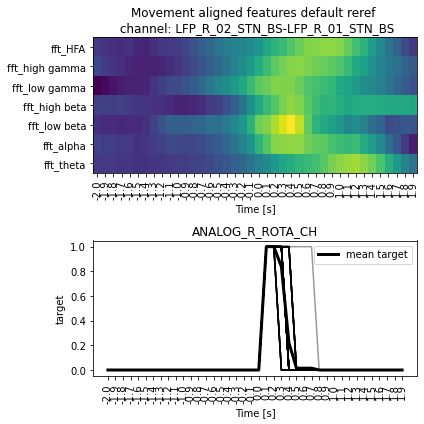

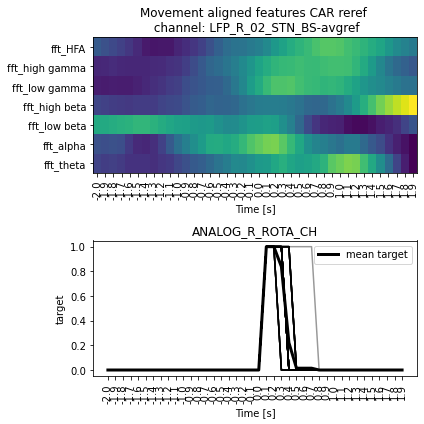

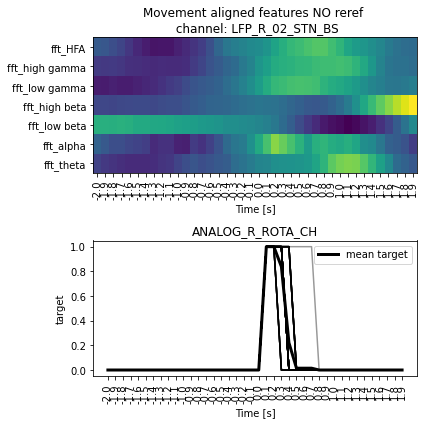

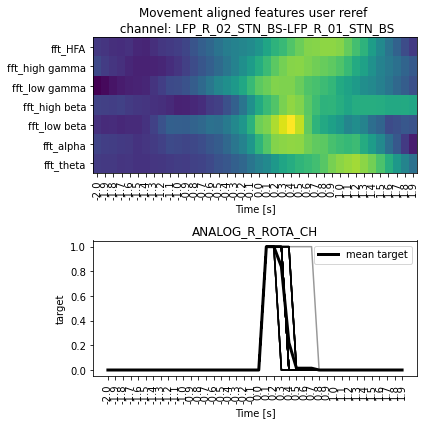

In [14]:
# init analyzer for default reref
feature_reader_default = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT, feature_file=RUN_NAME
)

# plot for a single channel
ch_used = "LFP_R_02_STN_BS-LFP_R_01_STN_BS"

feature_used_default = "fft"

feature_reader_default.feature_arr['ANALOG_R_ROTA_CH'] = (-1*feature_reader_default.feature_arr['ANALOG_R_ROTA_CH'] > 3e-7) * 1

feature_reader_default.label = feature_reader_default.feature_arr['ANALOG_R_ROTA_CH']

feature_reader_default.plot_target_averaged_channel(
    ch=ch_used,
    list_feature_keywords=[feature_used_default],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
    show_plot=True,
    title="Movement aligned features default reref \n"
)
#---------------------------------------
# init analyzer for CAR reref
feature_reader_avg = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_avg, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_avg = "LFP_R_02_STN_BS-avgref"

feature_used_avg = "fft"

feature_reader_avg.feature_arr['ANALOG_R_ROTA_CH'] = (-1*feature_reader_avg.feature_arr['ANALOG_R_ROTA_CH'] > 3e-7) * 1

feature_reader_avg.label = feature_reader_avg.feature_arr['ANALOG_R_ROTA_CH']


feature_reader_avg.plot_target_averaged_channel(
    ch=ch_used_avg,
    list_feature_keywords=[feature_used_avg],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
    show_plot=True,
    title="Movement aligned features CAR reref \n"
)
#--------------------------------------------------
# init analyzer NO reref
feature_reader_None = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_None, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_None = "LFP_R_02_STN_BS"

feature_used_None = "fft"

feature_reader_None.feature_arr['ANALOG_R_ROTA_CH'] = (-1*feature_reader_None.feature_arr['ANALOG_R_ROTA_CH'] > 3e-7) * 1

feature_reader_None.label = feature_reader_None.feature_arr['ANALOG_R_ROTA_CH']


feature_reader_None.plot_target_averaged_channel(
    ch=ch_used_None,
    list_feature_keywords=[feature_used_None],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
    show_plot=True,
    title="Movement aligned features NO reref \n"
)

#-----------------------------------------------
# init analyzer user reref
feature_reader_userRef = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_userRef, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_userRef = "LFP_R_02_STN_BS-LFP_R_01_STN_BS"

feature_used_userRef = "fft"

feature_reader_userRef.feature_arr['ANALOG_R_ROTA_CH'] = (-1*feature_reader_userRef.feature_arr['ANALOG_R_ROTA_CH'] > 3e-7) * 1

feature_reader_userRef.label = feature_reader_userRef.feature_arr['ANALOG_R_ROTA_CH']


feature_reader_userRef.plot_target_averaged_channel(
    ch=ch_used_userRef,
    list_feature_keywords=[feature_used_userRef],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
    show_plot=True,
    title="Movement aligned features user reref \n"
)

Take out mean target, put only one
# Change pictures in markdown


![alt](/home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_LFP_L_1_STN_BS_fft.png) | ![alt](/home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_LFP_L_1_STN_BS_fft.png) | ![alt](/home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_LFP_L_1_STN_BS_fft.png) | ![alt](/home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_LFP_L_1_STN_BS_fft.png)

# LFP_R_01_STN_BS-LFP_R_16_STN_BS in feature_reader_default.feature_arr.T and LFP_R_01_STN_BS in feature_reader_None.feature_arr.T are the same!!!!!!!!

In [15]:
feature_reader_default.feature_arr.T

,0,1,2,3,4,5,6,7,8,9,...,8021,8022,8023,8024,8025,8026,8027,8028,8029,8030
LFP_R_01_STN_BS-LFP_R_16_STN_BS_fft_theta,-1.719365,-2.202328,-2.350473,-2.295765,-2.099981,-1.863058,-1.635522,-1.514622,-1.536056,-1.693602,...,-5.987346,-5.938576,-6.007674,-6.072143,-5.998572,-6.023934,-5.918717,-5.970080,-6.010508,-6.048538
LFP_R_01_STN_BS-LFP_R_16_STN_BS_fft_alpha,-1.832897,-2.404817,-2.564213,-2.473012,-2.248494,-1.972603,-1.711700,-1.562714,-1.575153,-1.777708,...,-6.288980,-6.212917,-6.196100,-6.192659,-6.126519,-6.077463,-6.061731,-6.108836,-6.212631,-6.299899
LFP_R_01_STN_BS-LFP_R_16_STN_BS_fft_low beta,-1.871312,-2.480823,-2.661491,-2.567022,-2.352577,-2.078317,-1.824933,-1.678922,-1.708515,-1.953025,...,-6.501612,-6.471132,-6.458107,-6.453905,-6.439012,-6.418934,-6.376793,-6.357744,-6.314777,-6.359213
LFP_R_01_STN_BS-LFP_R_16_STN_BS_fft_high beta,-1.933777,-2.564437,-2.732655,-2.648850,-2.425159,-2.137761,-1.873142,-1.709403,-1.723016,-1.950732,...,-6.675635,-6.636735,-6.609273,-6.579517,-6.576188,-6.542876,-6.503364,-6.479854,-6.464440,-6.487442
LFP_R_01_STN_BS-LFP_R_16_STN_BS_fft_low gamma,-2.109400,-2.832182,-3.018839,-2.924815,-2.668323,-2.353810,-2.062006,-1.889244,-1.895038,-2.125176,...,-7.487885,-7.508933,-7.528105,-7.559952,-7.604085,-7.603694,-7.573834,-7.572640,-7.596560,-7.638058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LFP_L_15_STN_BS-LFP_L_14_STN_BS_fft_low gamma,-2.283352,-3.073724,-3.276750,-3.184425,-2.928931,-2.608326,-2.312441,-2.130032,-2.163280,-2.438223,...,-8.167396,-8.189791,-8.212628,-8.232701,-8.255392,-8.258799,-8.281681,-8.307661,-8.317234,-8.305530
LFP_L_15_STN_BS-LFP_L_14_STN_BS_fft_high gamma,-2.329566,-3.141011,-3.353033,-3.252988,-2.987380,-2.656059,-2.348689,-2.161476,-2.179281,-2.439892,...,-8.192746,-8.186017,-8.183193,-8.180547,-8.183245,-8.184398,-8.182467,-8.182233,-8.186139,-8.197156
LFP_L_15_STN_BS-LFP_L_14_STN_BS_fft_HFA,-2.334323,-3.144257,-3.350485,-3.253151,-2.989496,-2.658436,-2.350657,-2.166231,-2.186739,-2.453526,...,-8.276794,-8.276557,-8.277392,-8.276216,-8.276941,-8.270955,-8.263677,-8.262101,-8.261158,-8.260347
time,1000.000000,1100.000000,1200.000000,1300.000000,1400.000000,1500.000000,1600.000000,1700.000000,1800.000000,1900.000000,...,803100.000000,803200.000000,803300.000000,803400.000000,803500.000000,803600.000000,803700.000000,803800.000000,803900.000000,804000.000000


In [16]:
feature_reader_None.feature_arr.T

,0,1,2,3,4,5,6,7,8,9,...,8021,8022,8023,8024,8025,8026,8027,8028,8029,8030
LFP_R_01_STN_BS_fft_theta,-1.719365,-2.202328,-2.350473,-2.295765,-2.099981,-1.863058,-1.635522,-1.514622,-1.536056,-1.693602,...,-5.987346,-5.938576,-6.007674,-6.072143,-5.998572,-6.023934,-5.918717,-5.970080,-6.010508,-6.048538
LFP_R_01_STN_BS_fft_alpha,-1.832897,-2.404817,-2.564213,-2.473012,-2.248494,-1.972603,-1.711700,-1.562714,-1.575153,-1.777708,...,-6.288980,-6.212917,-6.196100,-6.192659,-6.126519,-6.077463,-6.061731,-6.108836,-6.212631,-6.299899
LFP_R_01_STN_BS_fft_low beta,-1.871312,-2.480823,-2.661491,-2.567022,-2.352577,-2.078317,-1.824933,-1.678922,-1.708515,-1.953025,...,-6.501612,-6.471132,-6.458107,-6.453905,-6.439012,-6.418934,-6.376793,-6.357744,-6.314777,-6.359213
LFP_R_01_STN_BS_fft_high beta,-1.933777,-2.564437,-2.732655,-2.648850,-2.425159,-2.137761,-1.873142,-1.709403,-1.723016,-1.950732,...,-6.675635,-6.636735,-6.609273,-6.579517,-6.576188,-6.542876,-6.503364,-6.479854,-6.464440,-6.487442
LFP_R_01_STN_BS_fft_low gamma,-2.109400,-2.832182,-3.018839,-2.924815,-2.668323,-2.353810,-2.062006,-1.889244,-1.895038,-2.125176,...,-7.487885,-7.508933,-7.528105,-7.559952,-7.604085,-7.603694,-7.573834,-7.572640,-7.596560,-7.638058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LFP_L_15_STN_BS_fft_low gamma,-2.226553,-2.977681,-3.158982,-3.056971,-2.802204,-2.489999,-2.203038,-2.020173,-2.030773,-2.270312,...,-7.755529,-7.778098,-7.816489,-7.838722,-7.865324,-7.886733,-7.897068,-7.912982,-7.963497,-7.973631
LFP_L_15_STN_BS_fft_high gamma,-2.257982,-3.053594,-3.252012,-3.155043,-2.893828,-2.570005,-2.271830,-2.091878,-2.109965,-2.366757,...,-7.909879,-7.942703,-7.973478,-8.009277,-8.032852,-8.059343,-8.082100,-8.107105,-8.122473,-8.134817
LFP_L_15_STN_BS_fft_HFA,-2.277598,-3.076597,-3.277812,-3.179900,-2.916940,-2.591405,-2.290931,-2.111376,-2.131404,-2.392734,...,-8.088423,-8.096472,-8.102375,-8.111359,-8.112594,-8.113072,-8.112179,-8.115430,-8.117742,-8.120660
time,1000.000000,1100.000000,1200.000000,1300.000000,1400.000000,1500.000000,1600.000000,1700.000000,1800.000000,1900.000000,...,803100.000000,803200.000000,803300.000000,803400.000000,803500.000000,803600.000000,803700.000000,803800.000000,803900.000000,804000.000000


Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/rereferencing_example_LFP_default.png


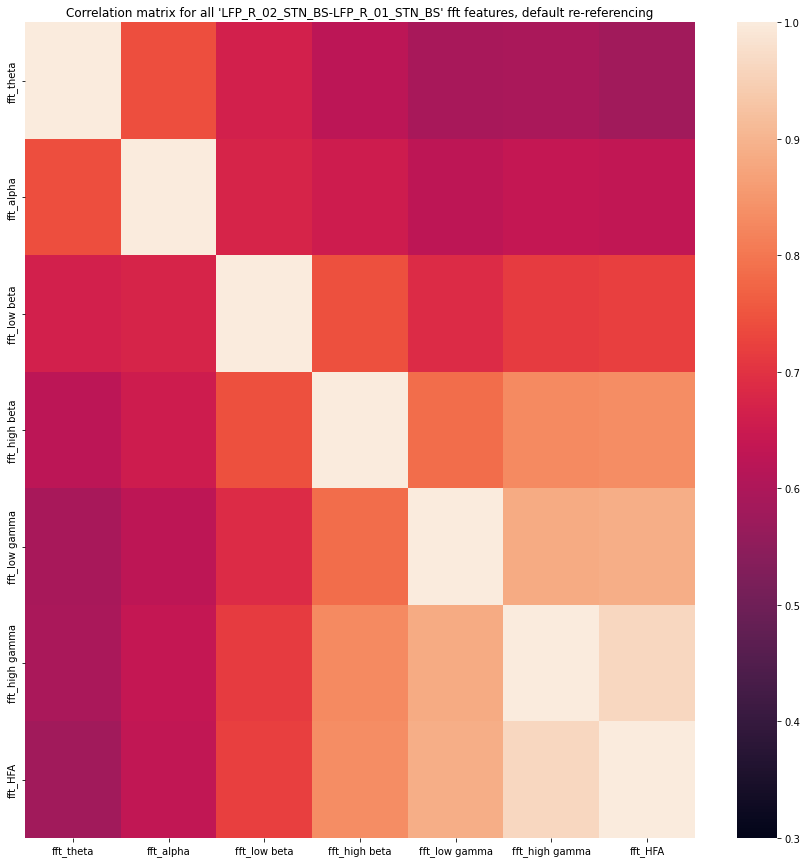

In [18]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_default.feature_arr.filter(regex="LFP_R_02_STN_BS-LFP_R_01_STN_BS"),
        OUT_PATH= PATH_OUT,
        feature_names=feature_reader_default.feature_arr.filter(regex="LFP_R_02_STN_BS-LFP_R_01_STN_BS").columns,
        feature_file=feature_reader_default.feature_file,
        ch_name="LFP_R_02_STN_BS-LFP_R_01_STN_BS",
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all 'LFP_R_02_STN_BS-LFP_R_01_STN_BS' fft features, default re-referencing",
        save_plot_name="rereferencing_example_LFP_default.png",
        cbar_vmin = 0.3,
        cbar_vmax= 1.
)

correlation plots for high beta, make same colobar lims


Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/rereferencing_example_LFP_avgref.png


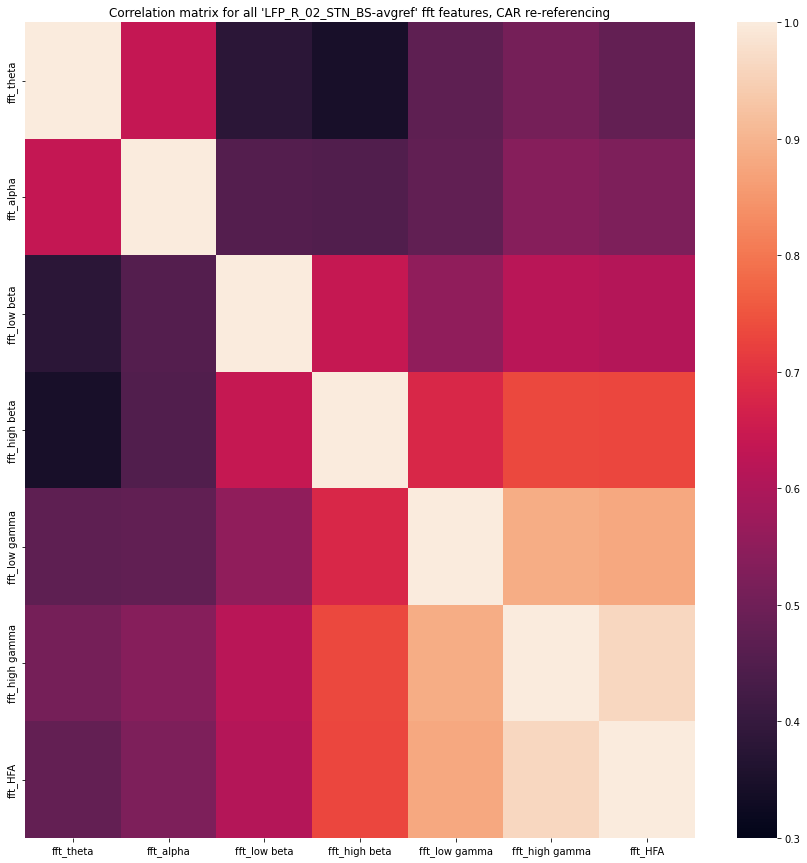

In [19]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_avg.feature_arr.filter(regex=ch_used_avg),
        OUT_PATH= PATH_OUT_avg,
        feature_names=feature_reader_avg.feature_arr.filter(regex=ch_used_avg).columns,
        feature_file=feature_reader_avg.feature_file,
        ch_name=ch_used_avg,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all 'LFP_R_02_STN_BS-avgref' fft features, CAR re-referencing",
        save_plot_name="rereferencing_example_LFP_avgref.png",
        cbar_vmin = 0.3,
        cbar_vmax= 1.
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/rereferencing_example_LFP_None.png


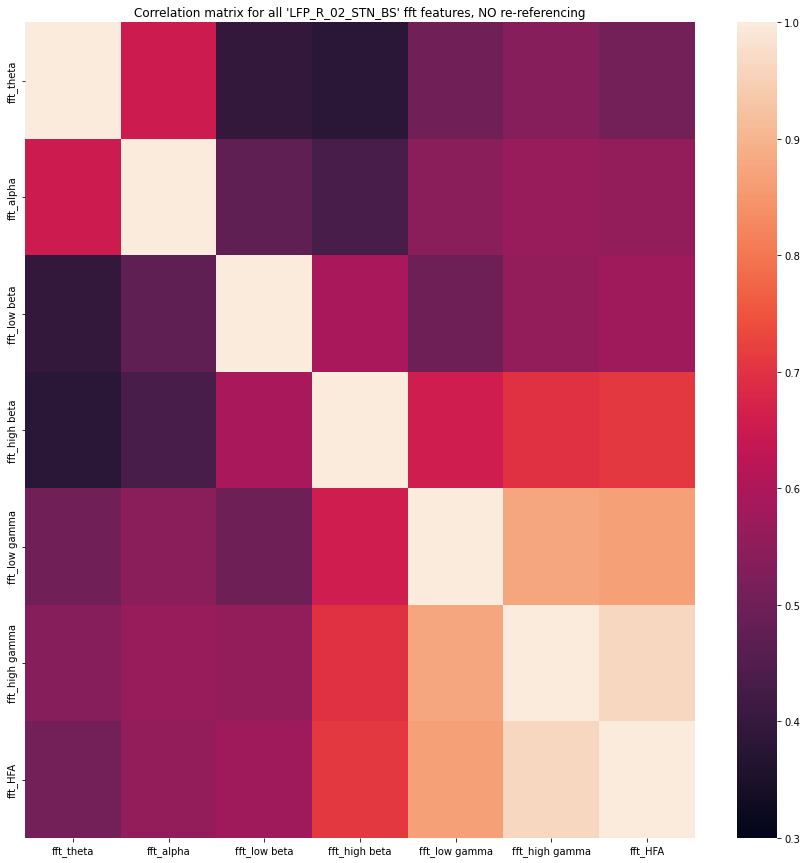

In [20]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_None.feature_arr.filter(regex=ch_used_None),
        OUT_PATH= PATH_OUT_None,
        feature_names=feature_reader_None.feature_arr.filter(regex=ch_used_None).columns,
        feature_file=feature_reader_None.feature_file,
        ch_name=ch_used_None,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all 'LFP_R_02_STN_BS' fft features, NO re-referencing",
        save_plot_name="rereferencing_example_LFP_None.png",
        cbar_vmin = 0.3,
        cbar_vmax= 1.
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/rereferencing_example_LFP_userRef.png


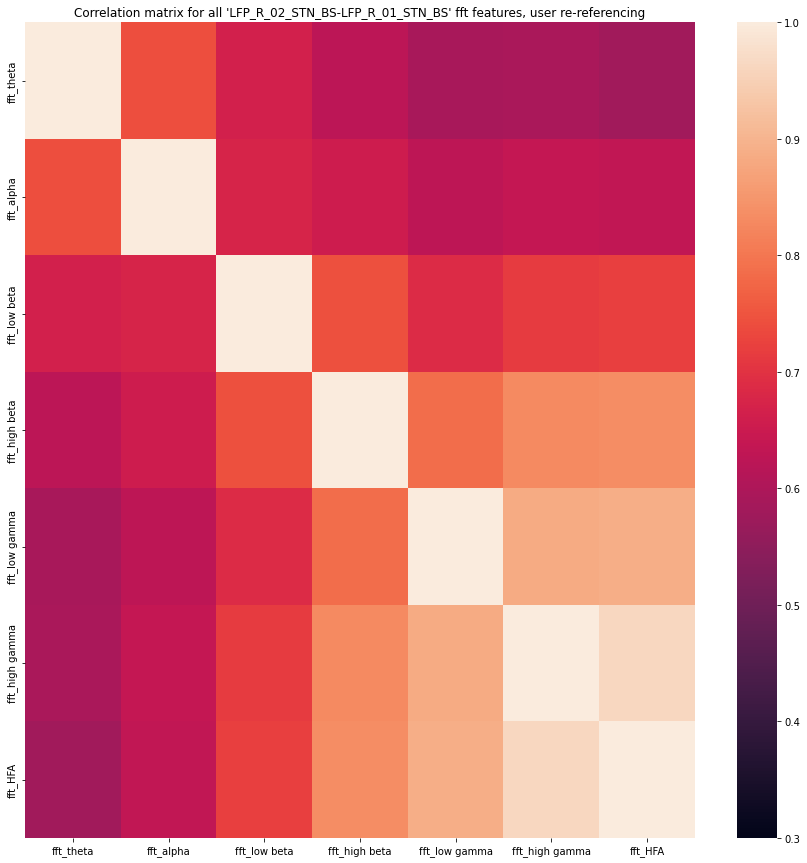

In [21]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_userRef.feature_arr.filter(regex=ch_used_userRef),
        OUT_PATH= PATH_OUT_userRef,
        feature_names=feature_reader_userRef.feature_arr.filter(regex=ch_used_userRef).columns,
        feature_file=feature_reader_userRef.feature_file,
        ch_name=ch_used_userRef,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all 'LFP_R_02_STN_BS-LFP_R_01_STN_BS' fft features, user re-referencing",
        save_plot_name="rereferencing_example_LFP_userRef.png",
        cbar_vmin = 0.3,
        cbar_vmax= 1.
)

### Compare decoding performances
We will run the decoding pipeline for both CAR and bipolar re-referenced cases and compare the performances.
Since the default settings for LFP data correspond to bipolar re-referencing, we will use the variables `_default` and compare them to `_avg`.


model being saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/sub-008_ses-EcogLfpMedOff01_task-SelfpacedRotationR_acq-StimOff_run-1/sub-008_ses-EcogLfpMedOff01_task-SelfpacedRotationR_acq-StimOff_run-1_LM_ML_RES.p


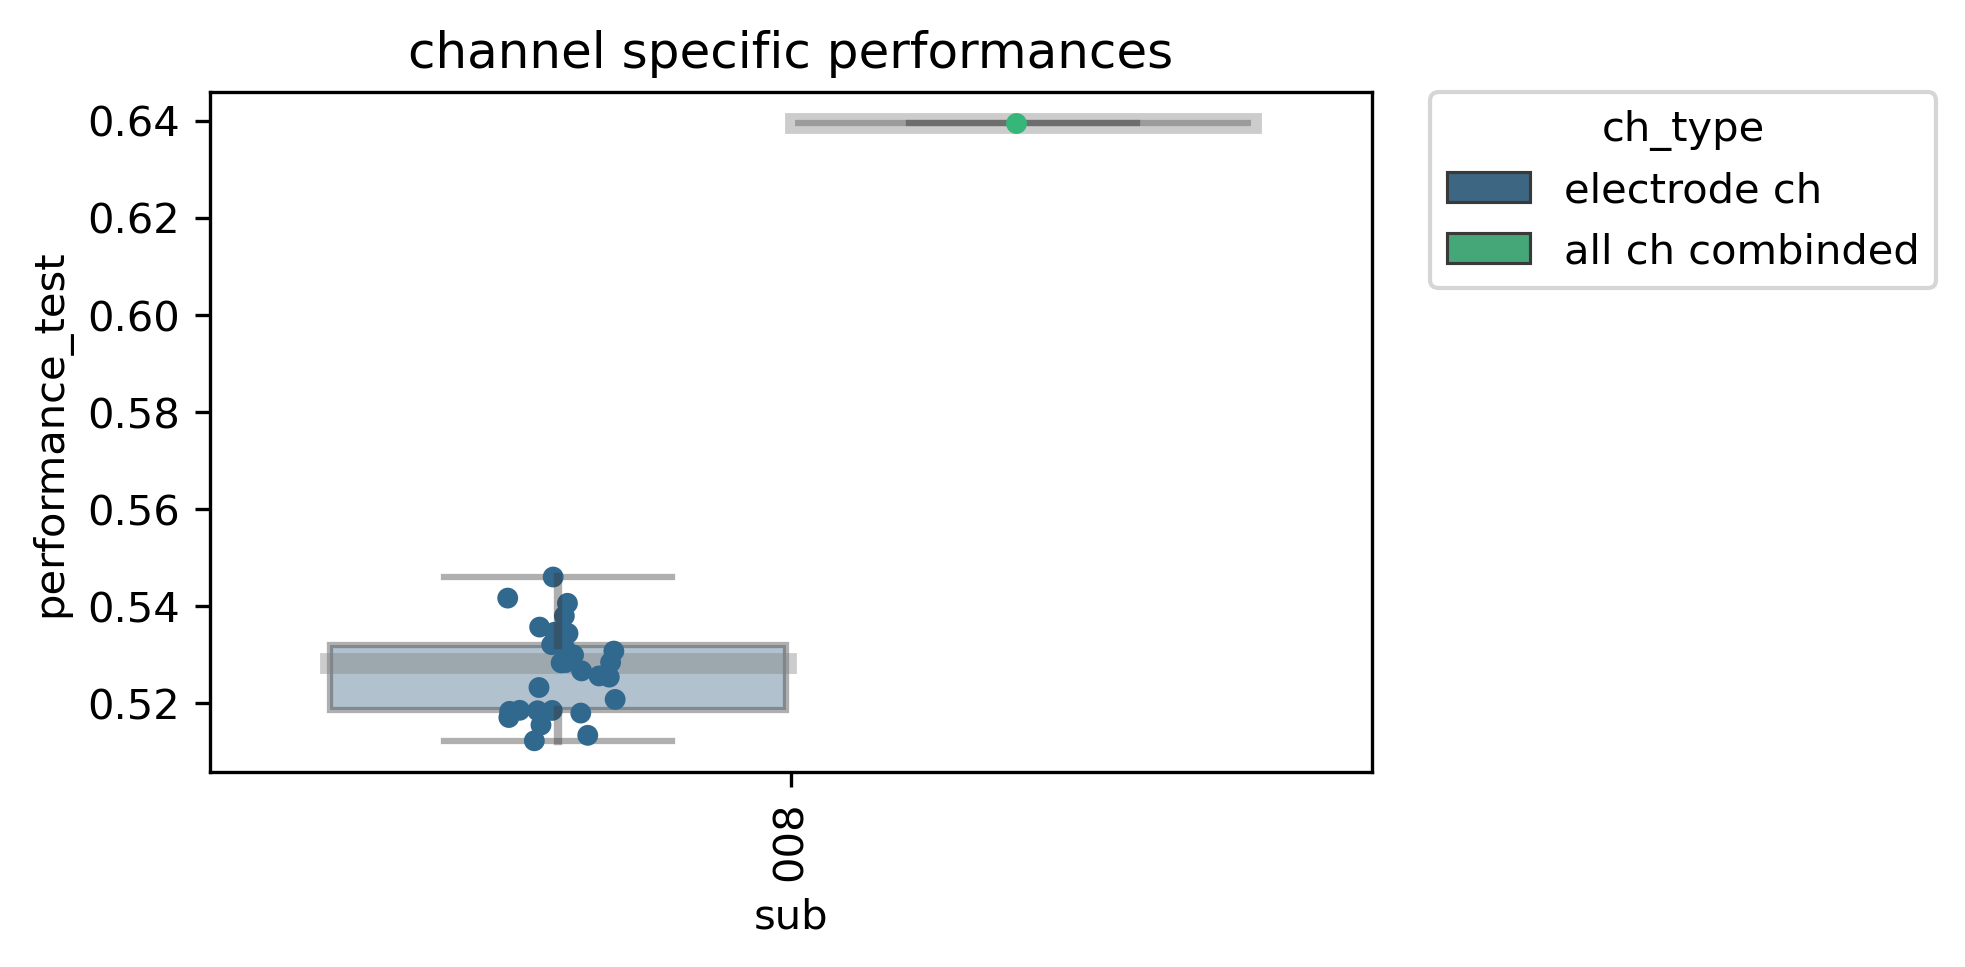

In [22]:
model = xgboost.XGBClassifier(use_label_encoder=False)


feature_reader_default.decoder = nm_decode.Decoder(
    features=feature_reader_default.feature_arr,
    label=feature_reader_default.label,
    label_name=feature_reader_default.label_name,
    used_chs=feature_reader_default.used_chs,
    model=model,
    eval_method=metrics.balanced_accuracy_score,
    cv_method=model_selection.KFold(n_splits=3, shuffle=True),
    get_movement_detection_rate=True,
    min_consequent_count=2,
    TRAIN_VAL_SPLIT=False,
    RUN_BAY_OPT=False,
    use_nested_cv=False,
    sfreq=feature_reader_default.settings["sampling_rate_features_hz"],
)

performances_default = feature_reader_default.run_ML_model(
    estimate_channels=True,
    estimate_gridpoints=False,
    estimate_all_channels_combined=True,
    save_results=True,
)

df_per_default = feature_reader_default.get_dataframe_performances(performances_default)

nm_plots.plot_df_subjects(
    df_per_default, x_col="sub", y_col="performance_test", hue="ch_type",
    PATH_SAVE=os.path.join(PATH_OUT, RUN_NAME, RUN_NAME + "_decoding_performance_default.png")
)

model being saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/sub-008_ses-EcogLfpMedOff01_task-SelfpacedRotationR_acq-StimOff_run-1/sub-008_ses-EcogLfpMedOff01_task-SelfpacedRotationR_acq-StimOff_run-1_LM_ML_RES.p


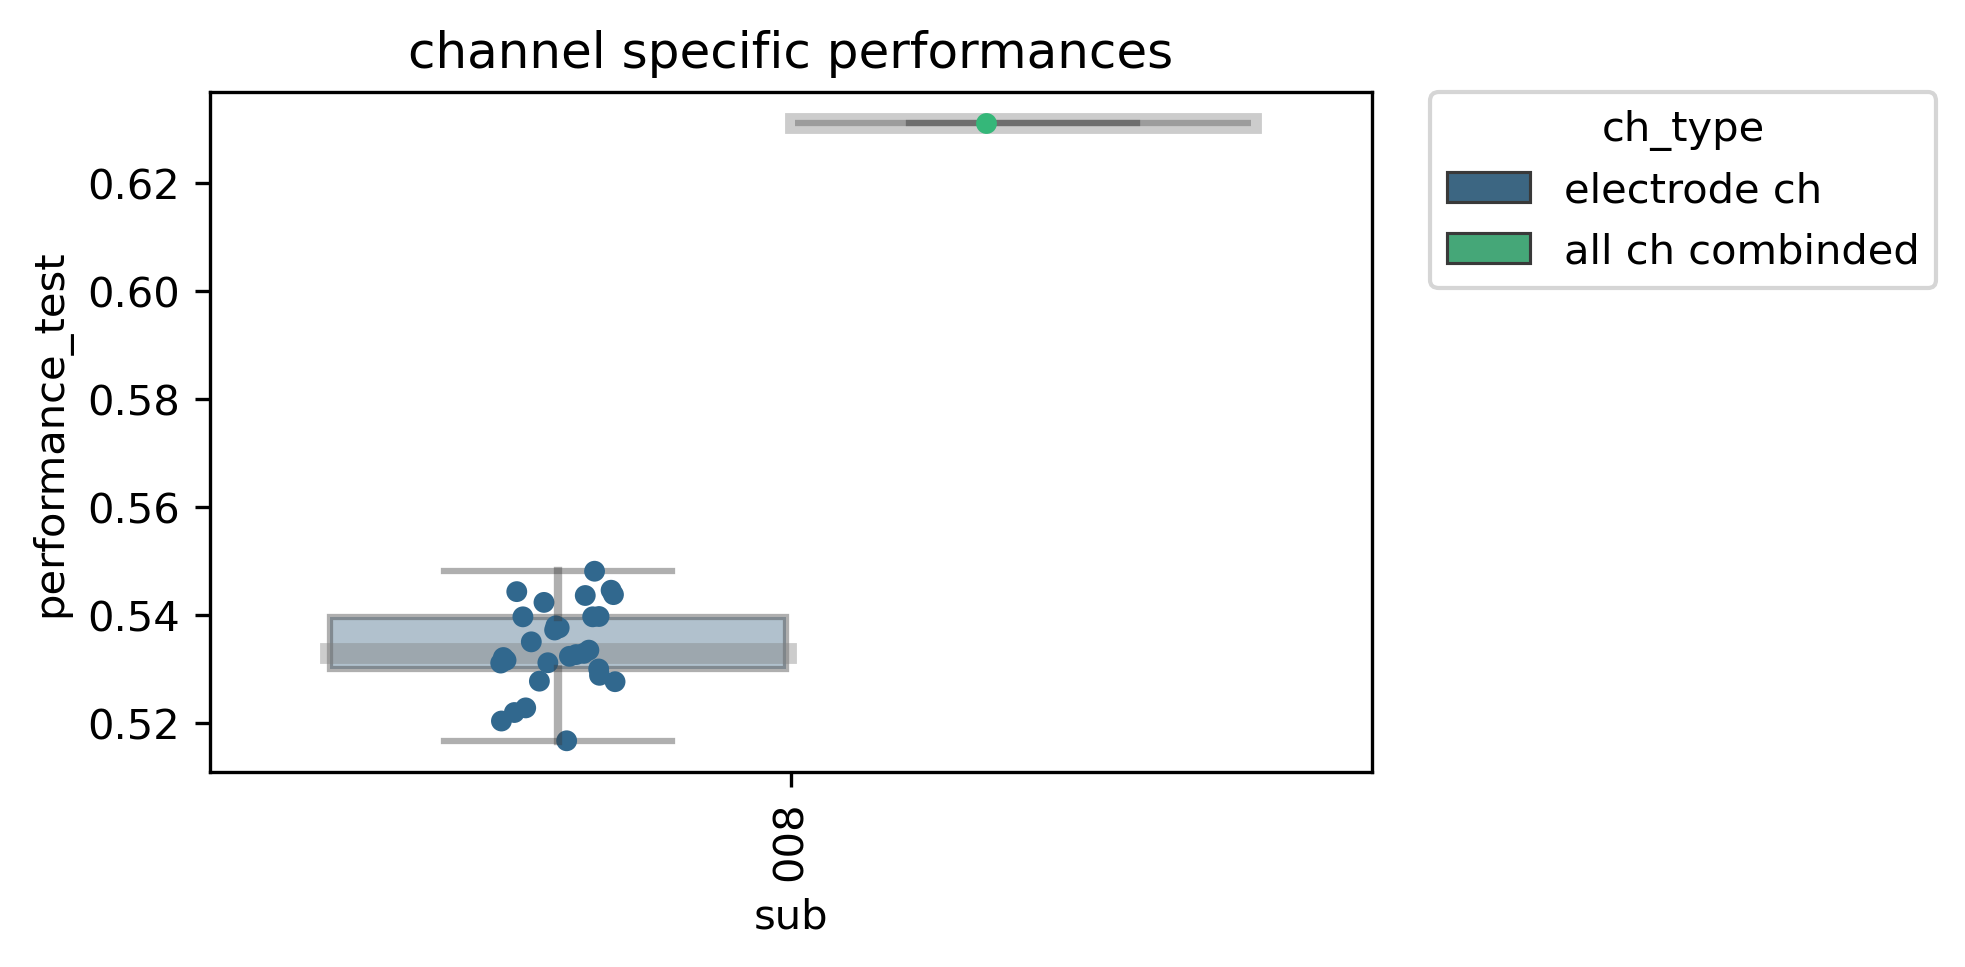

In [23]:
model = xgboost.XGBClassifier(use_label_encoder=False)


feature_reader_avg.decoder = nm_decode.Decoder(
    features=feature_reader_avg.feature_arr,
    label=feature_reader_avg.label,
    label_name=feature_reader_avg.label_name,
    used_chs=feature_reader_avg.used_chs,
    model=model,
    eval_method=metrics.balanced_accuracy_score,
    cv_method=model_selection.KFold(n_splits=3, shuffle=True),
    get_movement_detection_rate=True,
    min_consequent_count=2,
    TRAIN_VAL_SPLIT=False,
    RUN_BAY_OPT=False,
    use_nested_cv=False,
    sfreq=feature_reader_avg.settings["sampling_rate_features_hz"],
)

performances_avg = feature_reader_avg.run_ML_model(
    estimate_channels=True,
    estimate_gridpoints=False,
    estimate_all_channels_combined=True,
    save_results=True,
)

df_per_avg = feature_reader_avg.get_dataframe_performances(performances_default)

nm_plots.plot_df_subjects(
    df_per_avg, x_col="sub", y_col="performance_test", hue="ch_type",
    PATH_SAVE=os.path.join(PATH_OUT_avg, RUN_NAME, RUN_NAME + "_decoding_performance_avg.png")
)